<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/master/fpn_builder_svhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip uninstall -y tensorflow
! pip install -q tf-nightly==2.2.0.dev20200315
! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization==0.3.0.dev6

In [23]:
pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git

  Cloning https://github.com/kmkolasinski/keras_detection.git to /tmp/pip-req-build-0coylety
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-0coylety
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=62541 sha256=7b97030e5e5c7350371df6032fa4f327c7e623c5a61d988caaa579b5f9d35f76
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqwu62f7/wheels/9c/23/23/2d3299a84b3beda7addbe5f17af1aa74b0e15fd87214803132
Successfully built keras-detection
  Found existing installation: keras-detection 0.1
    Uninstalling keras-detection-0.1:
      Successfully uninstalled keras-detection-0.1


In [1]:
# test installation
import keras_detection
import tensorflow as tf
tf.__version__

'2.2.0-dev20200315'

# Download dataset
Download nad unpack SVHN dataset to datasets/SVHN/[train|test] folder

Download RAW data

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz

--2020-04-04 08:33:04--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  69.2MB/s    in 7.0s    

2020-04-04 08:33:11 (55.3 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-04-04 08:33:12--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  52.8MB/s    in 5.9s    

2020-04-04 08:33:18 (44.6 MB/s) - ‘test.tar.gz’ saved [276555967/2

In [0]:
!tar -xf train.tar.gz
!tar -xf test.tar.gz

# Load dataset 
Prepare and load SVHN dataset as tfrecrods, this will take a while ... 


In [2]:
from keras_detection.datasets.svhn.read_svhm_map import load_dataset

train_raw_dataset, num_train_examples = load_dataset('train')
test_raw_dataset, num_test_examples = load_dataset('test')

Loaded train.pkl dataset from existing pickle file. N=33402
Loaded test.pkl dataset from existing pickle file. N=13068


In [32]:
train_raw_dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [3]:
num_train_examples, num_test_examples

(33402, 13068)

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
keras = tf.keras

In [0]:
# disable tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
_logger.handlers.pop(0)

In [5]:
train_raw_dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

# Define model input and dataset parametres

In [0]:
num_classes = 10  # SVHN digits
image_dim = 128
batch_size = 64
num_epochs = -1
num_parallel_calls = tf.data.experimental.AUTOTUNE
num_test_steps = num_test_examples // batch_size

In [0]:
from keras_detection.datasets.datasets_ops import prepare_dataset

In [0]:
train_dataset = prepare_dataset(
    dataset=train_raw_dataset, 
    augmentation_fn=None,
    model_image_size=(image_dim, image_dim),
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle_buffer_size=1024,
    prefetch_buffer_size=8,
    num_parallel_calls=num_parallel_calls
)

test_dataset = prepare_dataset(
    dataset=test_raw_dataset, 
    augmentation_fn=None,
    model_image_size=(image_dim, image_dim),
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle_buffer_size=None,
    prefetch_buffer_size=2,
    num_parallel_calls=num_parallel_calls
)

# Define model

In [0]:
import keras_detection.backbones.mobilenetv2_customized as mobilenet
import keras_detection.tasks.standard_tasks as standard_tasks
import keras_detection.models.fpn_builder as fpn_builder
import keras_detection.models.utils as kd_utils
from keras_detection.utils import plotting

In [10]:
backbone = mobilenet.MobileNetV2Backbone(
    input_shape=[image_dim, image_dim, 3],
    alpha=1.0, min_fm_size=10, weights='imagenet'
)

tasks = [
    # predicts objectnes score for each anchor
    standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin"),
    # predicts [height, with, y, x ] location of the box
    standard_tasks.get_box_shape_task("box_shape"),
    # predicts [num_classes] for each anchor (focal loss is not supported yes)
    standard_tasks.get_multiclass_task(num_classes, fl_gamma=0.0, label_smoothing=0, activation='softmax'),
]

INFO:tensorflow:Loading pre-trained model weights: imagenet


In [11]:
builder = fpn_builder.FPNBuilder(backbone = backbone, tasks = tasks)
model = builder.build(batch_size=None)

INFO:tensorflow:Input image: (None, 128, 128, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7fee55d742b0>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm16x16)


In [12]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 128, 128, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Model)    (None, 16, 16, 320)  1566848     tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
model (Model)                   (None, 16, 16, 1)    184705      mobilenetv2_1.00_128[1][0]       
____________________________________________________________________________________________

# Train model

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [14]:
# Check the content of targets
prepared_train_dataset

<MapDataset shapes: ({image: (64, 128, 128, 3)}, {fm16x16/objectness: (64, 16, 16, 2), fm16x16/box_shape: (64, 16, 16, 5), fm16x16/classes: (64, 16, 16, 12)}), types: ({image: tf.float32}, {fm16x16/objectness: tf.float32, fm16x16/box_shape: tf.float32, fm16x16/classes: tf.float32})>

## Check targets
Visualize target boxes, target objectness and other 

In [0]:
features, labels = next(iter(prepared_train_dataset))

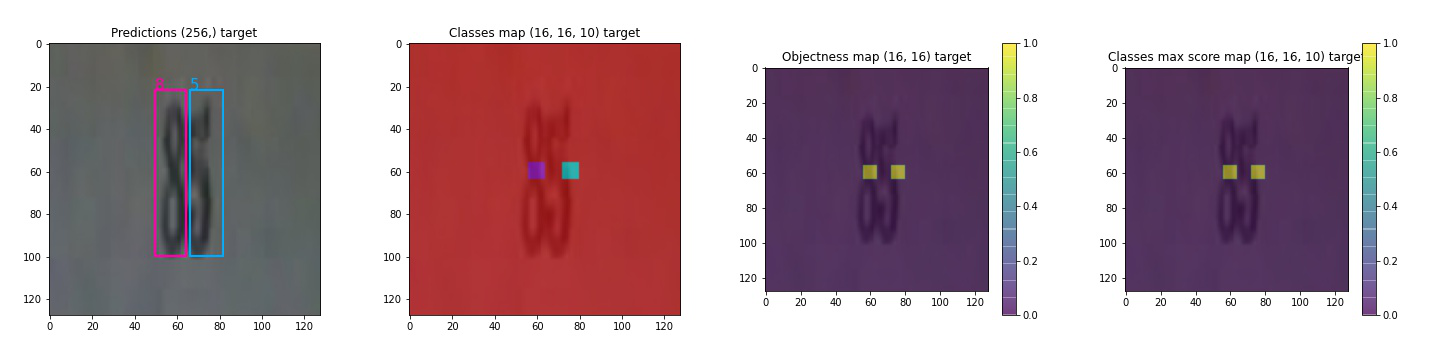

In [52]:
fm = "fm16x16"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 1
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

## Run training model

In [0]:

l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [18]:
model.losses, l2_reg_fn()

([<tf.Tensor: shape=(), dtype=float32, numpy=0.1784284>],
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1784284>)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=10, steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 151s 301ms/step - loss: 0.5604 - fm16x16/objectness_loss: 0.0689 - fm16x16/box_shape_loss: 0.0205 - fm16x16/classes_loss: 0.1145 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1243 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9156 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6906 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0637 - fm16x16/classes_MulticlassAccuracyMetric: 0.1930
Epoch 2/10
500/500 [==============================] - 151s 302ms/step - loss: 0.3550 - fm16x16/objectness_loss: 0.0244 - fm16x16/box_shape_loss: 0.0150 - fm16x16/classes_loss: 0.0362 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1674 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9476 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8248 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0318 - fm16x16/classes_MulticlassAccuracyMetric: 0.3113
Epoch 3/10
500/500 [==============================] - 150s 301ms/step - loss: 0.3055 -

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.99)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 150s 300ms/step - loss: 0.3099 - fm16x16/objectness_loss: 0.0208 - fm16x16/box_shape_loss: 0.0137 - fm16x16/classes_loss: 0.0297 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1741 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9575 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8412 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0290 - fm16x16/classes_MulticlassAccuracyMetric: 0.5296
Epoch 2/5
500/500 [==============================] - 150s 300ms/step - loss: 0.3074 - fm16x16/objectness_loss: 0.0203 - fm16x16/box_shape_loss: 0.0135 - fm16x16/classes_loss: 0.0291 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1772 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9593 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8455 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0286 - fm16x16/classes_MulticlassAccuracyMetric: 0.5599
Epoch 3/5
500/500 [==============================] - 150s 300ms/step - loss: 0.3078 - fm

There will be a gap between training metrics and evaluation metrics, which comes from the presence of BatchNorm. There will be also a gap between train and test datasets which signalizes the overfitting. 

In [21]:
builder.evaluate_model(model, test_dataset, num_test_steps)

204/204 [==============================] - 16s 80ms/step - loss: 0.3278 - fm16x16/objectness_loss: 0.0274 - fm16x16/box_shape_loss: 0.0143 - fm16x16/classes_loss: 0.0314 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1945 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8473 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6510 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0192 - fm16x16/classes_MulticlassAccuracyMetric: 0.3988


[0.32783564925193787,
 0.027440713718533516,
 0.014333270490169525,
 0.031426191329956055,
 0.19446206092834473,
 0.8473244309425354,
 0.6510282754898071,
 0.019239500164985657,
 0.39881402254104614]

In [22]:
builder.evaluate_model(model, train_dataset, num_test_steps)

204/204 [==============================] - 16s 80ms/step - loss: 0.3252 - fm16x16/objectness_loss: 0.0241 - fm16x16/box_shape_loss: 0.0145 - fm16x16/classes_loss: 0.0305 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1964 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9268 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.7281 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0226 - fm16x16/classes_MulticlassAccuracyMetric: 0.5367


[0.32521215081214905,
 0.024058770388364792,
 0.014496973715722561,
 0.030547628179192543,
 0.19644096493721008,
 0.9268253445625305,
 0.7280843257904053,
 0.0225659366697073,
 0.5366548895835876]

In [0]:
!mkdir --parents models

In [0]:
model.save_weights("models/non-quantized-model.h5")

In [0]:
model.load_weights("models/non-quantized-model.h5")

# Test trained model

In [43]:
builder.evaluate_model(model, test_dataset, num_test_steps)

204/204 [==============================] - 16s 79ms/step - loss: 0.2022 - fm16x16/objectness_loss: 0.0274 - fm16x16/box_shape_loss: 0.0143 - fm16x16/classes_loss: 0.0314 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1945 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8473 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6510 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0192 - fm16x16/classes_MulticlassAccuracyMetric: 0.3988


[0.20219963788986206,
 0.027440713718533516,
 0.014333270490169525,
 0.031426191329956055,
 0.19446206092834473,
 0.8473244309425354,
 0.6510282754898071,
 0.019239500164985657,
 0.39881402254104614]

In [0]:
prepared_test_dataset = test_dataset.map(builder.get_build_training_targets_fn())
dataset_iterator = iter(prepared_test_dataset)

In [0]:
features, labels = next(dataset_iterator)
predictions = model.predict(features)
predictions = builder.predictions_to_dict(predictions, postprocess=True)

In [46]:
builder.get_outputs_names()

['fm16x16/objectness', 'fm16x16/box_shape', 'fm16x16/classes']

In [0]:
fm = "fm16x16"
targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

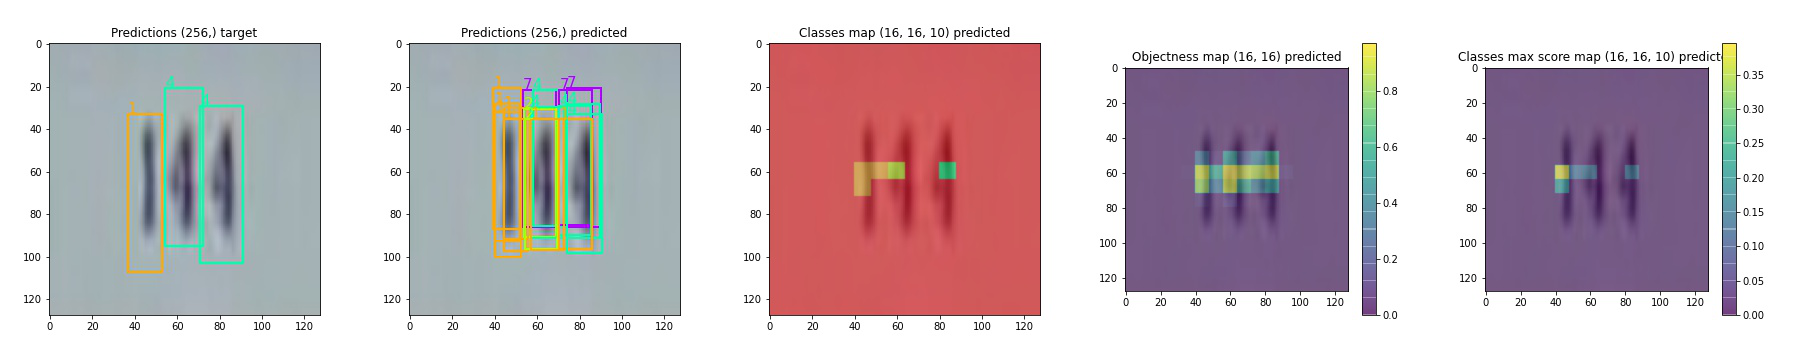

In [58]:
# select index of image in batch
idx = 8
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

predicted=dict(
    objectness=predictions[f'{fm}/objectness'][idx],
    boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
    classes_map=predictions[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=predicted,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.1,
)
render

# Quantize model
Convert model to quantized version and initialize its weights with previosuly pretrained model

In [15]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5"
)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Input image: (None, 128, 128, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7fee55d742b0>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm16x16)
INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 128, 128, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7fee55d742b0>
INFO:tensorflow:Running quantization for model backbone: mobilenetv2_1.00_128
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm16x16)
INFO:tensorflow:Running quantization for head: 'fm16x16/objectness'
INFO:tensorf

In [23]:
quantized_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_4 (TensorFl [(None, 128, 128, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Model)    (None, 16, 16, 320)  1581907     tf_op_layer_RealDiv_4[0][0]      
__________________________________________________________________________________________________
model_9 (Model)                 (None, 16, 16, 1)    184846      mobilenetv2_1.00_128[1][0]       
___________________________________________________________________________________________

In [61]:
# test metrics after quantization, they should be much worse
builder.evaluate_model(quantized_model, test_dataset, num_test_steps)

204/204 [==============================] - 35s 174ms/step - loss: 2.6749 - fm16x16/objectness_loss: 0.0318 - fm16x16/box_shape_loss: 0.0246 - fm16x16/classes_loss: 2.3969 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1928 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8318 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6157 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0205 - fm16x16/classes_MulticlassAccuracyMetric: 0.0559


[2.6748971939086914,
 0.031838927417993546,
 0.02461167611181736,
 2.396941661834717,
 0.19284814596176147,
 0.8317691683769226,
 0.6157084703445435,
 0.020511183887720108,
 0.05586191639304161]

# Train quantized model

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [64]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=10, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/10
500/500 [==============================] - 328s 657ms/step - loss: 0.5181 - fm16x16/objectness_loss: 0.0263 - fm16x16/box_shape_loss: 0.0278 - fm16x16/classes_loss: 0.0970 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1693 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9364 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8124 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0300 - fm16x16/classes_MulticlassAccuracyMetric: 0.2868
Epoch 2/10
500/500 [==============================] - 327s 654ms/step - loss: 0.3321 - fm16x16/objectness_loss: 0.0209 - fm16x16/box_shape_loss: 0.0169 - fm16x16/classes_loss: 0.0410 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1785 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9550 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8439 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0286 - fm16x16/classes_MulticlassAccuracyMetric: 0.3393
Epoch 3/10
500/500 [==============================] - 327s 654ms/step - loss: 0.2894 -

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=10, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/10
500/500 [==============================] - 325s 651ms/step - loss: 0.2492 - fm16x16/objectness_loss: 0.0175 - fm16x16/box_shape_loss: 0.0126 - fm16x16/classes_loss: 0.0521 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1900 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9669 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8715 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0271 - fm16x16/classes_MulticlassAccuracyMetric: 0.4955
Epoch 2/10
500/500 [==============================] - 325s 650ms/step - loss: 0.2355 - fm16x16/objectness_loss: 0.0166 - fm16x16/box_shape_loss: 0.0122 - fm16x16/classes_loss: 0.0429 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1925 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9700 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8754 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0267 - fm16x16/classes_MulticlassAccuracyMetric: 0.5313
Epoch 3/10
500/500 [==============================] - 324s 648ms/step - loss: 0.2327 -

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

## Evalute quantized model

In [17]:
builder.evaluate_model(quantized_model, test_dataset, num_test_steps)

204/204 [==============================] - 37s 180ms/step - loss: 0.1881 - fm16x16/objectness_loss: 0.0200 - fm16x16/box_shape_loss: 0.0124 - fm16x16/classes_loss: 0.0438 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1895 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9306 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8317 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0237 - fm16x16/classes_MulticlassAccuracyMetric: 0.4416


[0.1881173998117447,
 0.020040404051542282,
 0.012432479299604893,
 0.04375215992331505,
 0.18950694799423218,
 0.9306004643440247,
 0.8317399024963379,
 0.023725498467683792,
 0.44157207012176514]

## Visualize predictions from quanized model

In [0]:
prepared_test_dataset = test_dataset.map(builder.get_build_training_targets_fn())
dataset_iterator = iter(prepared_test_dataset)

In [0]:
features, labels = next(dataset_iterator)
predictions = quantized_model.predict(features)
predictions = builder.predictions_to_dict(predictions, postprocess=True)
fm = "fm16x16"
targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

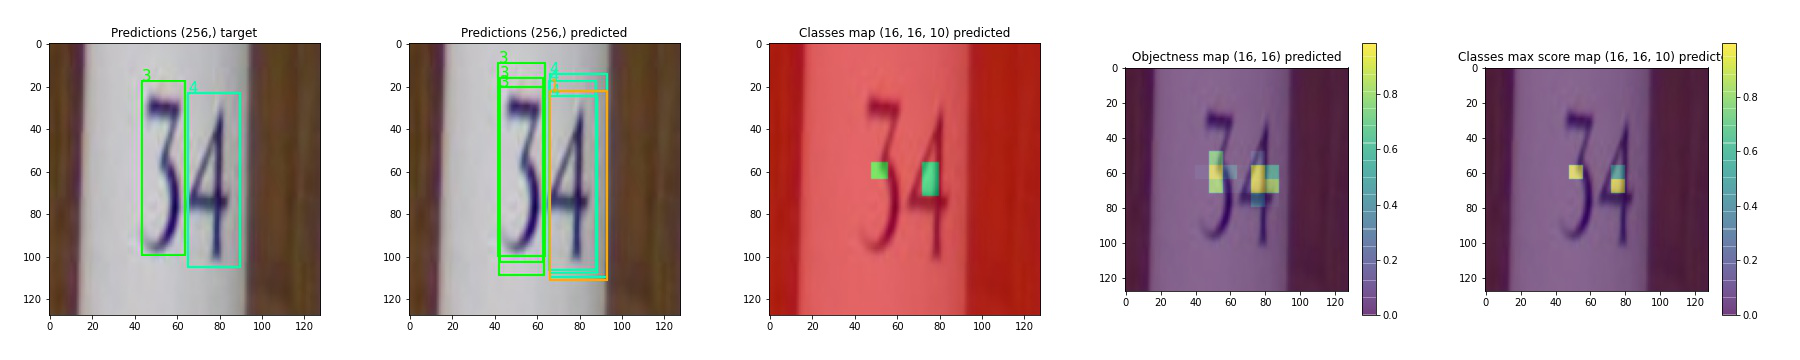

In [20]:
# select index of image in batch
idx = 10
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

predicted=dict(
    objectness=predictions[f'{fm}/objectness'][idx],
    boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
    classes_map=predictions[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=predicted,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.4,
)
render

# Export model to tflite
Conversion is done with:
```python
    converter = from_keras_model(model)
    converter.experimental_new_converter = True
    converter.experimental_new_quantizer = True
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
```

In [21]:
# creates two versions of the model:  
#  - models/quantized-model.tflite
#  - models/quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = test_raw_dataset,  # representative dataset
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=True # use representative dataset to generate integer quantized model 
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity:0", shape=(1, 256), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity:0", shape=(1, 256, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes/Identity:0", shape=(1, 256, 10), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Testing tflite model for N=1 iterations ..


INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([  1, 128, 128,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 184,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 256,   4], dtype=int32),
  'shape_signature': array([  1, 256,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 190,
  'name': 'export/classes/output'

INFO:tensorflow:Test finished in 1.551214 seconds


INFO:tensorflow:Model saved to models/quantized-model.tflite


INFO:tensorflow:Model saved to models/quantized-model.tflite


INFO:tensorflow:Converting quantized model


INFO:tensorflow:Converting quantized model


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Testing tflite model for N=1 iterations ..


INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([  1, 128, 128,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 180,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 256,   4], dtype=int32),
  'shape_signature': array([  1, 256,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 190,
  'name': 'export/classes/output'

INFO:tensorflow:Test finished in 1.612783 seconds


INFO:tensorflow:Quantized model saved to models/quantized-model.quantized.tflite


INFO:tensorflow:Quantized model saved to models/quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: quantized-model.tflite


INFO:tensorflow:Testing converted model: quantized-model.tflite


INFO:tensorflow:Testing converted model: quantized-model.tflite


INFO:tensorflow:Testing converted model: quantized-model.tflite
100%|██████████| 16/16 [00:28<00:00,  1.80s/it]

INFO:tensorflow:Measured deviation between keras and tflite model:



INFO:tensorflow:Measured deviation between keras and tflite model:


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.007927 
	RMSE    =  0.035783 
	Keras   = N(μ=  0.030039, σ=  0.143009)
	tflite  = N(μ=  0.027251, σ=  0.135665)
 - export/box_shape/output   
	MAE     =  0.006279 
	RMSE    =  0.013210 
	Keras   = N(μ=  0.413126, σ=  0.267102)
	tflite  = N(μ=  0.413811, σ=  0.267155)
 - export/classes/output     
	MAE     =  0.000658 
	RMSE    =  0.013667 
	Keras   = N(μ=  0.000562, σ=  0.012718)
	tflite  = N(μ=  0.000589, σ=  0.012788)


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.007927 
	RMSE    =  0.035783 
	Keras   = N(μ=  0.030039, σ=  0.143009)
	tflite  = N(μ=  0.027251, σ=  0.135665)
 - export/box_shape/output   
	MAE     =  0.006279 
	RMSE    =  0.013210 
	Keras   = N(μ=  0.413126, σ=  0.267102)
	tflite  = N(μ=  0.413811, σ=  0.267155)
 - export/classes/output     
	MAE     =  0.000658 
	RMSE    =  0.013667 
	Keras   = N(μ=  0.000562, σ=  0.012718)
	tflite  = N(μ=  0.000589, σ=  0.012788)


INFO:tensorflow:Testing converted model: quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: quantized-model.quantized.tflite
100%|██████████| 16/16 [00:27<00:00,  1.71s/it]

INFO:tensorflow:Measured deviation between keras and tflite model:



INFO:tensorflow:Measured deviation between keras and tflite model:


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.000759 
	RMSE    =  0.003540 
	Keras   = N(μ=  0.030039, σ=  0.143009)
	tflite  = N(μ=  0.030201, σ=  0.143635)
 - export/box_shape/output   
	MAE     =  0.001983 
	RMSE    =  0.003444 
	Keras   = N(μ=  0.413126, σ=  0.267102)
	tflite  = N(μ=  0.413075, σ=  0.266314)
 - export/classes/output     
	MAE     =  0.000494 
	RMSE    =  0.011030 
	Keras   = N(μ=  0.000562, σ=  0.012718)
	tflite  = N(μ=  0.000565, σ=  0.013538)


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.000759 
	RMSE    =  0.003540 
	Keras   = N(μ=  0.030039, σ=  0.143009)
	tflite  = N(μ=  0.030201, σ=  0.143635)
 - export/box_shape/output   
	MAE     =  0.001983 
	RMSE    =  0.003444 
	Keras   = N(μ=  0.413126, σ=  0.267102)
	tflite  = N(μ=  0.413075, σ=  0.266314)
 - export/classes/output     
	MAE     =  0.000494 
	RMSE    =  0.011030 
	Keras   = N(μ=  0.000562, σ=  0.012718)
	tflite  = N(μ=  0.000565, σ=  0.013538)


In [22]:
exported_model, tflite_models_paths 

(<tensorflow.python.keras.engine.training.Model at 0x7fed947c2e10>,
 [PosixPath('models/quantized-model.tflite'),
  PosixPath('models/quantized-model.quantized.tflite')])

# Create box-predictor from converted model

In [23]:
box_detector = builder.as_box_detector("models/quantized-model.h5", is_quantized=True)

INFO:tensorflow:Building quantized model with batch_size = None


INFO:tensorflow:Building quantized model with batch_size = None


INFO:tensorflow:Building graph with quantization enabled


INFO:tensorflow:Building graph with quantization enabled


INFO:tensorflow:Input image: (None, 128, 128, 3)


INFO:tensorflow:Input image: (None, 128, 128, 3)


INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7fee55d742b0>


INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7fee55d742b0>


INFO:tensorflow:Running quantization for model backbone: mobilenetv2_1.00_128


INFO:tensorflow:Running quantization for model backbone: mobilenetv2_1.00_128


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow: Processing feature map (fm16x16)


INFO:tensorflow: Processing feature map (fm16x16)


INFO:tensorflow:Running quantization for head: 'fm16x16/objectness'


INFO:tensorflow:Running quantization for head: 'fm16x16/objectness'


INFO:tensorflow:Running quantization for head: 'fm16x16/box_shape'


INFO:tensorflow:Running quantization for head: 'fm16x16/box_shape'


INFO:tensorflow:Running quantization for head: 'fm16x16/classes'


INFO:tensorflow:Running quantization for head: 'fm16x16/classes'


INFO:tensorflow:Merging feature maps


INFO:tensorflow:Merging feature maps


INFO:tensorflow:Export outputs


INFO:tensorflow:Export outputs


INFO:tensorflow:- objectness           - Tensor("objectness_1/Identity:0", shape=(None, 256), dtype=float32)


INFO:tensorflow:- objectness           - Tensor("objectness_1/Identity:0", shape=(None, 256), dtype=float32)


INFO:tensorflow:- box_shape            - Tensor("box_shape_1/Identity:0", shape=(None, 256, 4), dtype=float32)


INFO:tensorflow:- box_shape            - Tensor("box_shape_1/Identity:0", shape=(None, 256, 4), dtype=float32)


INFO:tensorflow:- classes              - Tensor("classes_1/Identity:0", shape=(None, 256, 10), dtype=float32)


INFO:tensorflow:- classes              - Tensor("classes_1/Identity:0", shape=(None, 256, 10), dtype=float32)


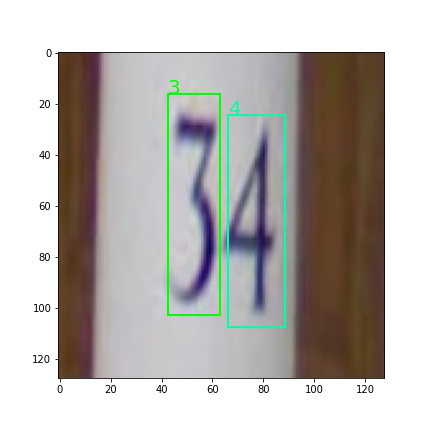

In [28]:
predictions = box_detector.predict(features['image'])
predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)

INFO:tensorflow:Building box predictor for TFLite model


INFO:tensorflow:Building box predictor for TFLite model


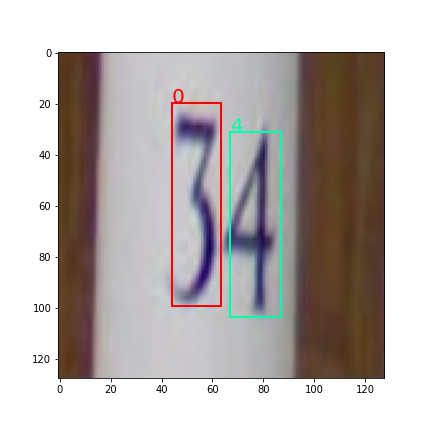

In [30]:
# prediction from integer quantized model will take a while on the GPU
tflite_box_detector =  builder.as_box_detector("models/quantized-model.tflite")
predictions = tflite_box_detector.predict(features['image'])
predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)

INFO:tensorflow:Building box predictor for TFLite model


INFO:tensorflow:Building box predictor for TFLite model


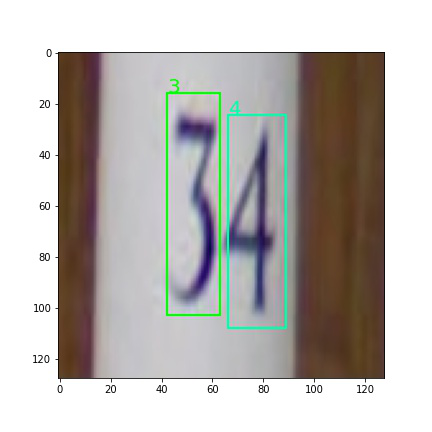

In [31]:
# load model converted using representative dataset
tflite_box_detector =  builder.as_box_detector("models/quantized-model.quantized.tflite")
predictions = tflite_box_detector.predict(features['image'])
predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)